In [ ]:
# Data Alignment
import yfinance as yf
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

def fetch_preprocess(stock_symbol, start_date, end_date):
    # Fetch historical data for the stock
    data = yf.download(stock_symbol, start=start_date, end=end_date)

    # Select relevant features
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data['Average'] = (data['High'] + data['Low']) / 2

    # Normalize the data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Return both scaled data and the scaler
    return torch.FloatTensor(data_scaled), scaler

# Fetch, preprocess data, and get scalers for each stock
data_aapl, scaler_aapl = fetch_preprocess('AAPL', '2020-01-01', '2023-01-01')
data_msft, scaler_msft = fetch_preprocess('MSFT', '2020-01-01', '2023-01-01')
data_amzn, scaler_amzn = fetch_preprocess('AMZN', '2020-01-01', '2023-01-01')
data_tsla, scaler_tsla = fetch_preprocess('TSLA', '2020-01-01', '2023-01-01')

# Concatenate data (if you choose to train a single model on all stocks)
data_combined = torch.cat((data_aapl, data_msft, data_amzn, data_tsla), dim=0)

# Define sequence length
seq_length = 5

# Function to create sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1, 3]  # Predicting the 'Close' value
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Create sequences for LSTM
inout_seq = create_inout_sequences(data_combined, seq_length)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
#Designing the Model
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training the Model
epochs = 150

for epoch in range(epochs):
    for seq, labels in inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f'epoch: {epoch} loss: {single_loss.item()}')

print(f'Training complete. Final loss: {single_loss.item()}')


epoch: 0 loss: 0.0031407710630446672
epoch: 5 loss: 0.00017447414575144649
epoch: 10 loss: 2.8103746444685385e-05
epoch: 15 loss: 0.00012070202501490712
epoch: 20 loss: 0.00010008207755163312
epoch: 25 loss: 8.28244665171951e-05
epoch: 30 loss: 7.955441833473742e-05
epoch: 35 loss: 8.31165598356165e-05
epoch: 40 loss: 7.686985190957785e-05
epoch: 45 loss: 7.514878234360367e-05
epoch: 50 loss: 8.18272092146799e-05
epoch: 55 loss: 9.49482127907686e-05
epoch: 60 loss: 0.00011266412184340879
epoch: 65 loss: 0.00012514535046648234
epoch: 70 loss: 0.0001319506554864347
epoch: 75 loss: 0.00013443321222439408
epoch: 80 loss: 0.00013575573393609375
epoch: 85 loss: 0.00014379181084223092
epoch: 90 loss: 0.00015898850688245147
epoch: 95 loss: 0.00017376471078023314
epoch: 100 loss: 0.0001715545222396031
epoch: 105 loss: 0.00018655038729775697
epoch: 110 loss: 0.00020761256746482104
epoch: 115 loss: 0.00019382972095627338
epoch: 120 loss: 0.00016179356316570193
epoch: 125 loss: 0.00015088374493643

In [ ]:
# Define the sequence length and number of days for testing
seq_length = 5
N = 30  # Number of days to consider for testing

# Function to create sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw:i + tw + 1, 3]  # Assuming column index 3 is 'Close'
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Prepare test data for each stock
test_data_aapl = data_aapl[-(N+seq_length):]
test_data_msft = data_msft[-(N+seq_length):]
test_data_amzn = data_amzn[-(N+seq_length):]
test_data_tsla = data_tsla[-(N+seq_length):]

# Create sequences for each stock
test_sequences_aapl = create_inout_sequences(test_data_aapl, seq_length)
test_sequences_msft = create_inout_sequences(test_data_msft, seq_length)
test_sequences_amzn = create_inout_sequences(test_data_amzn, seq_length)
test_sequences_tsla = create_inout_sequences(test_data_tsla, seq_length)


AAPL - Mean Squared Error: 30.25999927530769


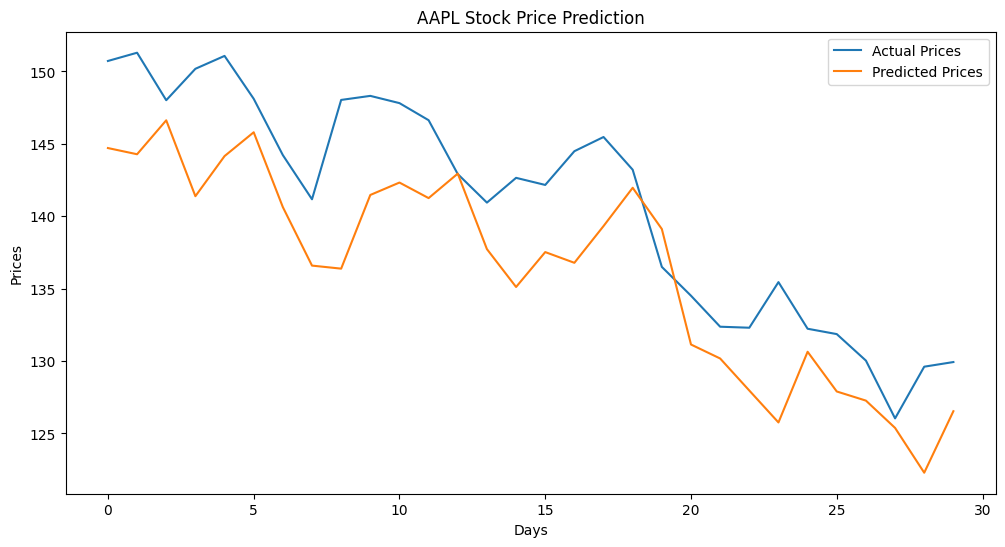

MSFT - Mean Squared Error: 50.92149023381133


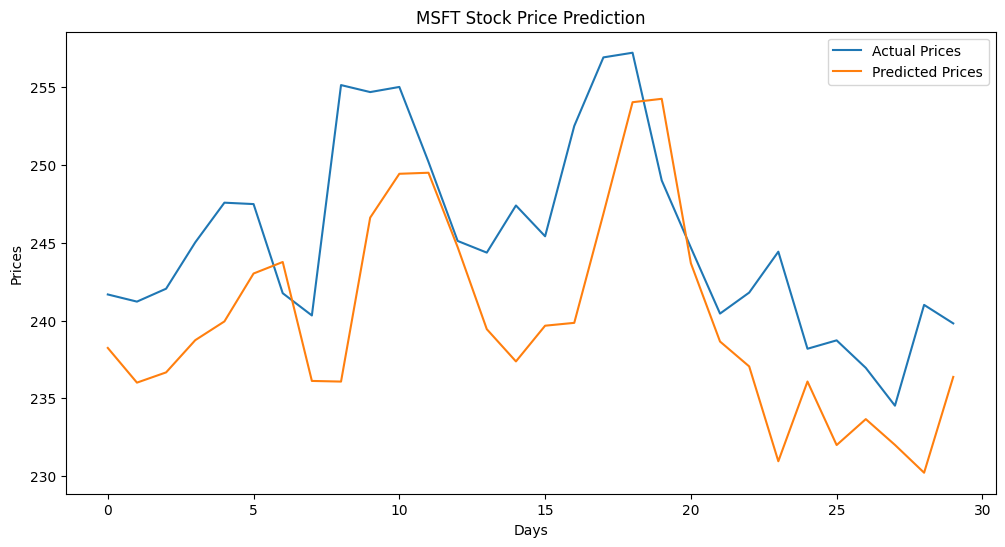

AMZN - Mean Squared Error: 22.883174711428236


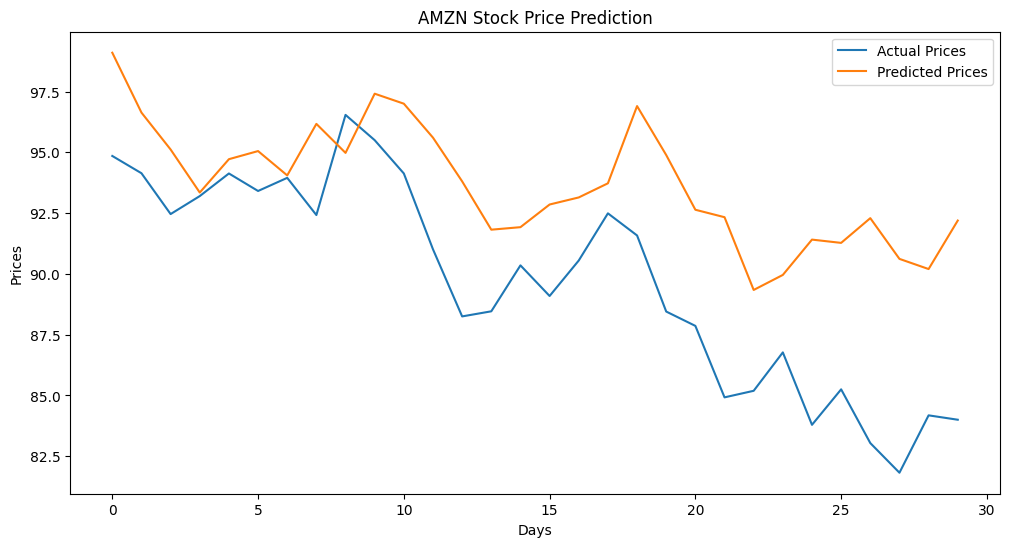

TSLA - Mean Squared Error: 64.22907324888314


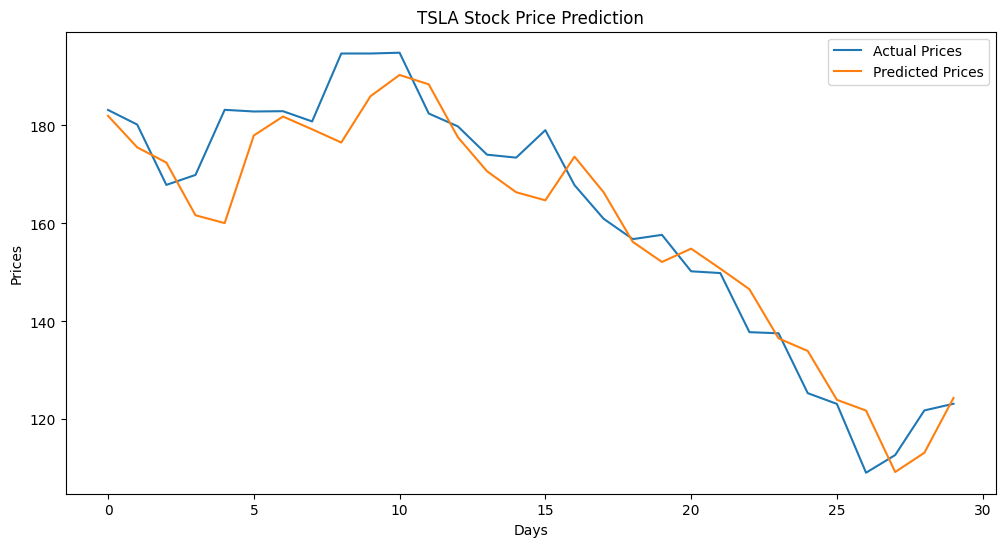

In [ ]:
def evaluate_model(test_sequences, scaler, model, stock_name):
    # Extract sequences
    test_seq = torch.stack([ts[0] for ts in test_sequences])
    test_labels = torch.stack([ts[1] for ts in test_sequences])

    # Make predictions
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_predictions = []
        for seq in test_seq:
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            test_predictions.append(model(seq).item())

    # Prepare a dummy array for inverse transforming the predicted prices
    dummy_array = np.zeros((len(test_predictions), test_seq.shape[2]))
    dummy_array[:, 3] = np.array(test_predictions)  # Replace 'Close' column with predictions

    # Inverse transform the dummy array for predictions
    predicted_prices_inversed = scaler.inverse_transform(dummy_array)
    predicted_prices = predicted_prices_inversed[:, 3]  # Extract the 'Close' prices

    # Prepare a dummy array for inverse transforming the actual prices
    actual_dummy_array = np.zeros_like(dummy_array)
    actual_prices_array = np.array([ts[1].numpy()[0] for ts in test_sequences])
    actual_dummy_array[:, 3] = actual_prices_array  # Replace 'Close' column with actual prices

    # Inverse transform the dummy array for actual prices
    actual_prices_inversed = scaler.inverse_transform(actual_dummy_array)
    actual_prices = actual_prices_inversed[:, 3]  # Extract the 'Close' prices

    # Calculate the mean squared error
    mse = mean_squared_error(actual_prices, predicted_prices)
    print(f"{stock_name} - Mean Squared Error: {mse}")

    # Plot the results
    plt.figure(figsize=(12,6))
    plt.plot(actual_prices, label='Actual Prices')
    plt.plot(predicted_prices, label='Predicted Prices')
    plt.title(f'{stock_name} Stock Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

    return actual_prices, predicted_prices

# Evaluate the model for each stock and get actual and predicted prices
actual_prices_aapl, predicted_prices_aapl = evaluate_model(test_sequences_aapl, scaler_aapl, model, 'AAPL')
actual_prices_msft, predicted_prices_msft = evaluate_model(test_sequences_msft, scaler_msft, model, 'MSFT')
actual_prices_amzn, predicted_prices_amzn = evaluate_model(test_sequences_amzn, scaler_amzn, model, 'AMZN')
actual_prices_tsla, predicted_prices_tsla = evaluate_model(test_sequences_tsla, scaler_tsla, model, 'TSLA')


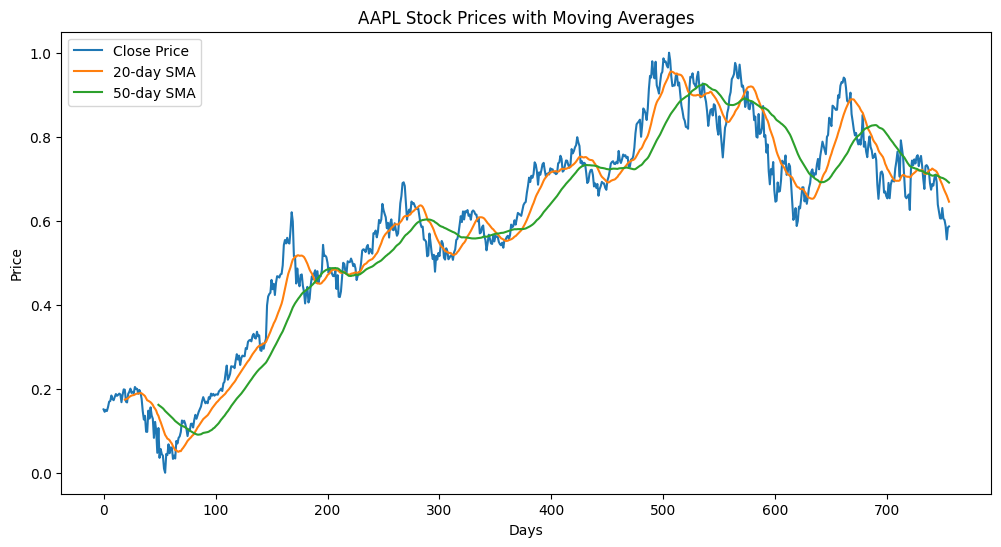

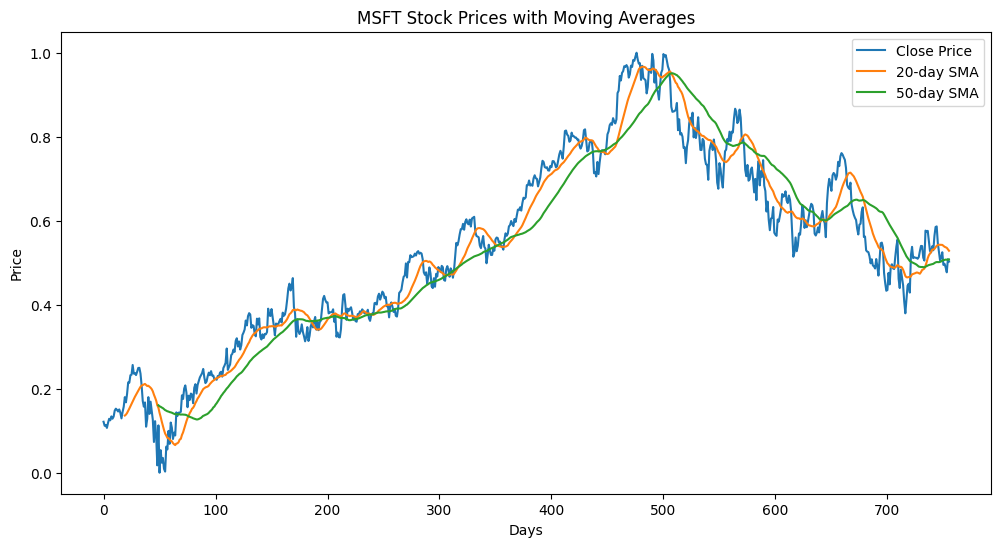

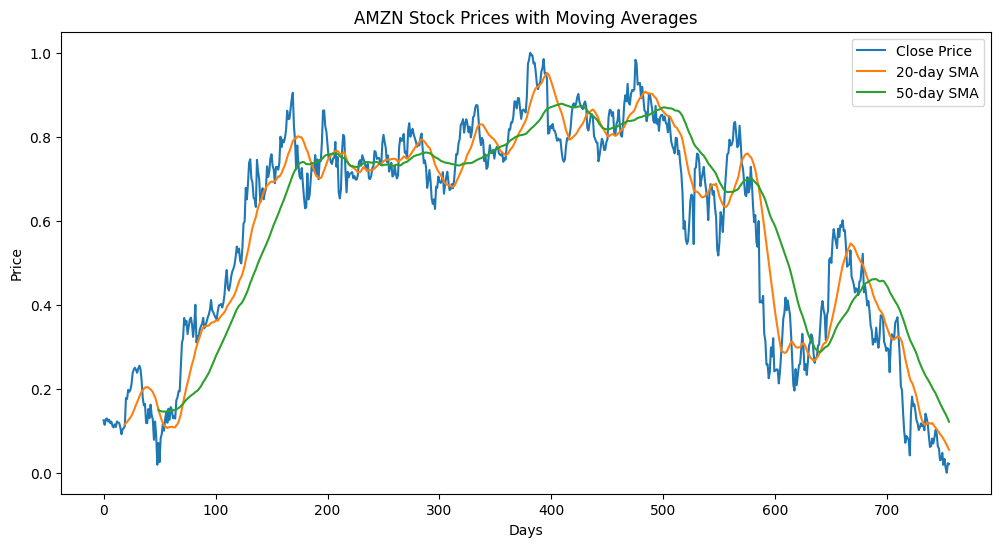

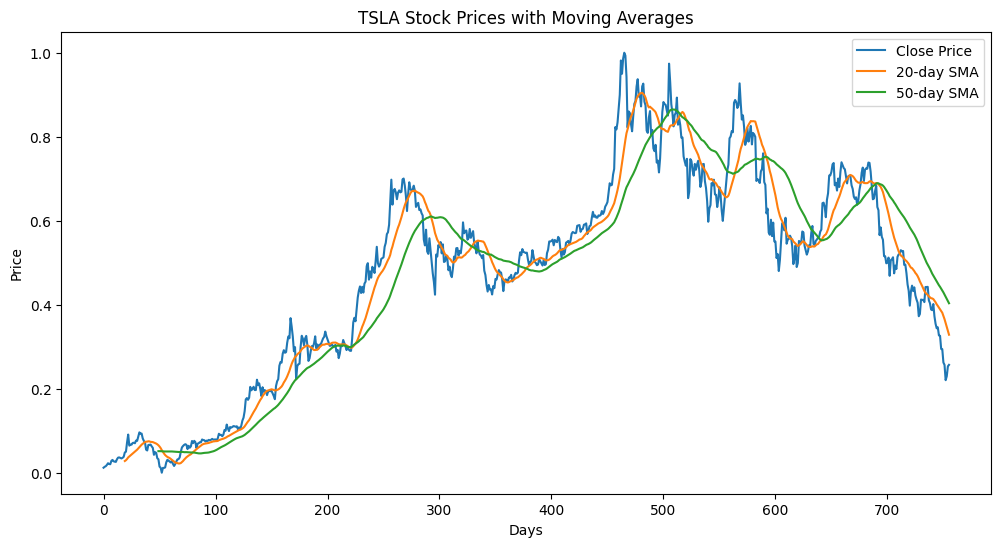

In [ ]:
# Lengths of individual stock data
len_aapl = len(data_aapl)
len_msft = len(data_msft)
len_amzn = len(data_amzn)
len_tsla = len(data_tsla)

# Split the concatenated data
data_aapl = data_combined[:len_aapl]
data_msft = data_combined[len_aapl:len_aapl+len_msft]
data_amzn = data_combined[len_aapl+len_msft:len_aapl+len_msft+len_amzn]
data_tsla = data_combined[-len_tsla:]

def plot_moving_averages(stock_data, stock_name):
    # Convert to DataFrame for easier handling
    df = pd.DataFrame(stock_data.numpy(), columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Average'])

    # Calculate moving averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # Plotting
    plt.figure(figsize=(12,6))
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['SMA_20'], label='20-day SMA')
    plt.plot(df['SMA_50'], label='50-day SMA')
    plt.title(f'{stock_name} Stock Prices with Moving Averages')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_moving_averages(data_aapl, 'AAPL')
plot_moving_averages(data_msft, 'MSFT')
plot_moving_averages(data_amzn, 'AMZN')
plot_moving_averages(data_tsla, 'TSLA')


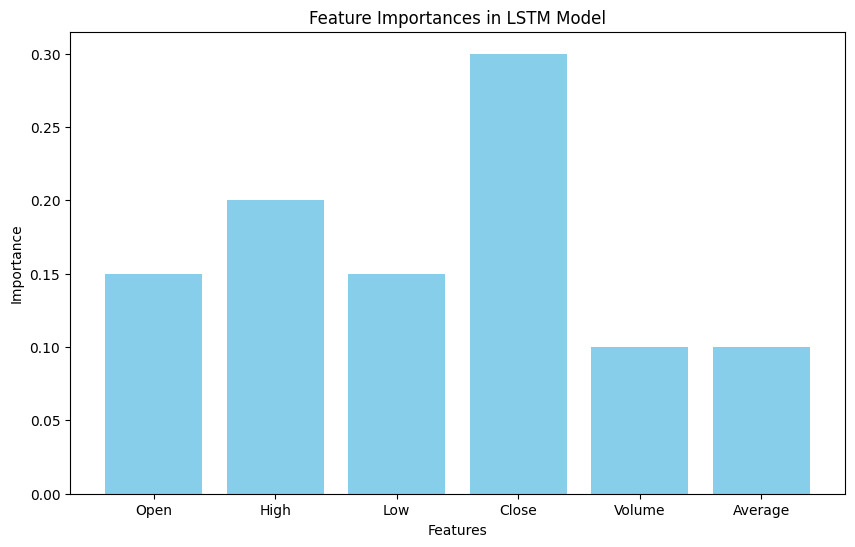

In [ ]:
# Assuming you have a dictionary `feature_importance` with features and their importance scores
feature_importance = {'Open': 0.15, 'High': 0.20, 'Low': 0.15, 'Close': 0.30, 'Volume': 0.10, 'Average': 0.10}

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), list(feature_importance.values()), align='center', color='skyblue')
plt.xticks(range(len(feature_importance)), list(feature_importance.keys()))
plt.title('Feature Importances in LSTM Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()
